---
title: "Splitting plots into functions"
author: "Damien Martin"
date: "2024-04-29 15:30"
categories: [data-vis, plotnine, snippet]
image: "image.jpg"
description: "Shows how to decompose a plot into different functions, with the goal of being able to modularize the code used."
---

# Problem

We want to be able to build up our plots in library functions.

This is most useful when we want to annotate a standard graph -- by having a function that creates the plot, and then being able to call the function and continue adding things to the plot. Conceptually:

```python
plot_sales(df)
# Shows a plot of sales


# This doesn't work, but want to highlight a particular month
plot_sales(df) + p9.geom_rect(
    mapping=p9.aes(xmin='2024-03-01', xmax='2024-04-01', ymin=float("-inf"), ymax=float("inf"))
)
```

# Solution

Make a list instead, and add the list.

The above example, done correctly, is 

```python
plot_sales(df)
# Shows a plot of sales


# This DOES work
plot_sales(df) + [
    p9.geom_rect(mapping=p9.aes(xmin='2024-03-01', xmax='2024-04-01', ymin=float("-inf"), ymax=float("inf")))
]
```

# Minimal Example

In [1]:
import plotnine as p9
from plotnine.data import mtcars

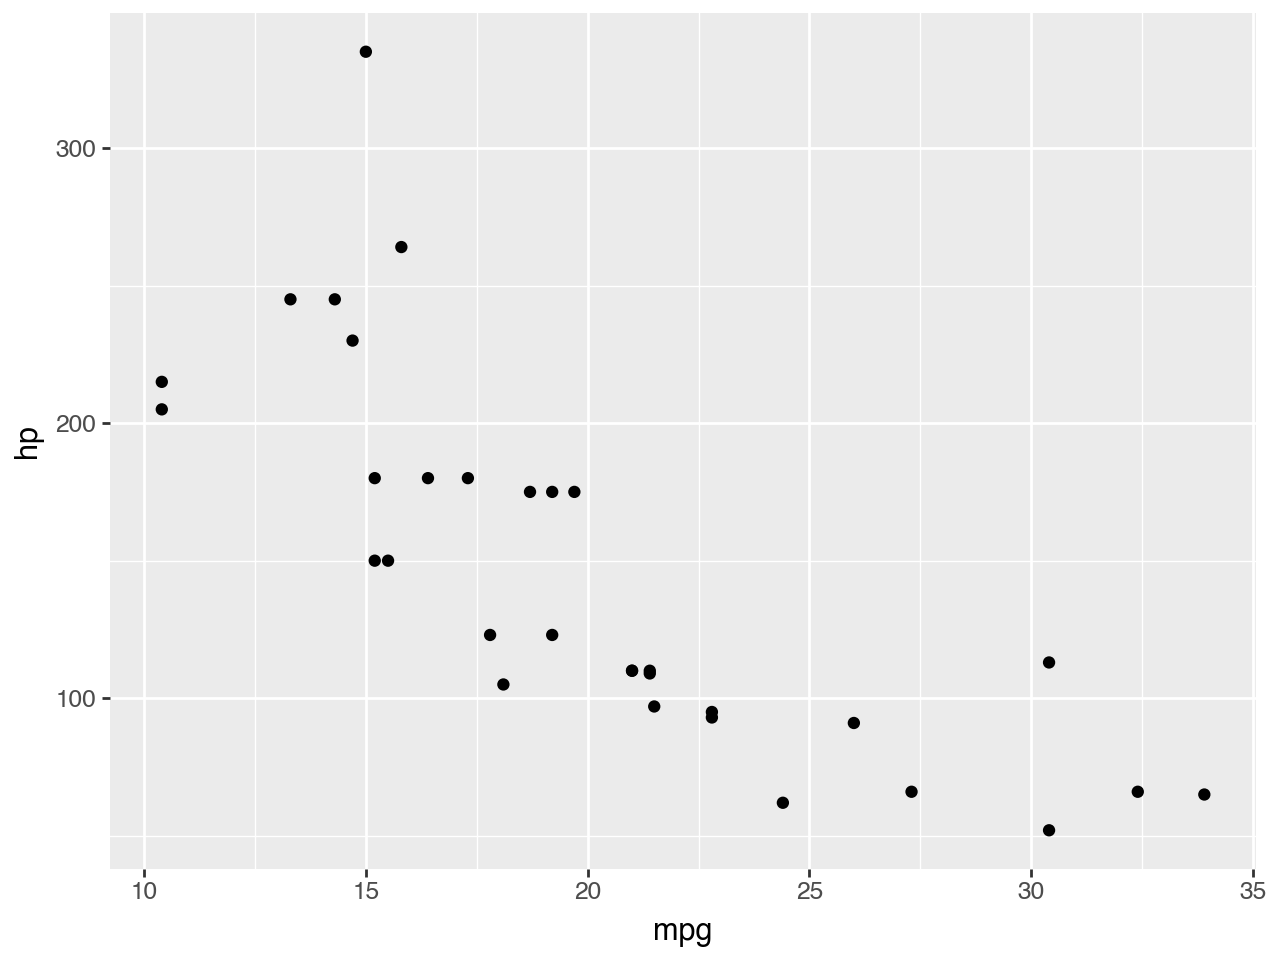

In [2]:
original = (
    p9.ggplot(mtcars, p9.aes(x='mpg', y='hp'))
    + p9.geom_point()
)
original

Let's say that this is the type of graph we would normally create (e.g. we could make a function that generates it, and only takes the data frame as input).

If we watned to take this same graph and add to it for a particular report, we can add a list of `plotnine` objects, as shown below:

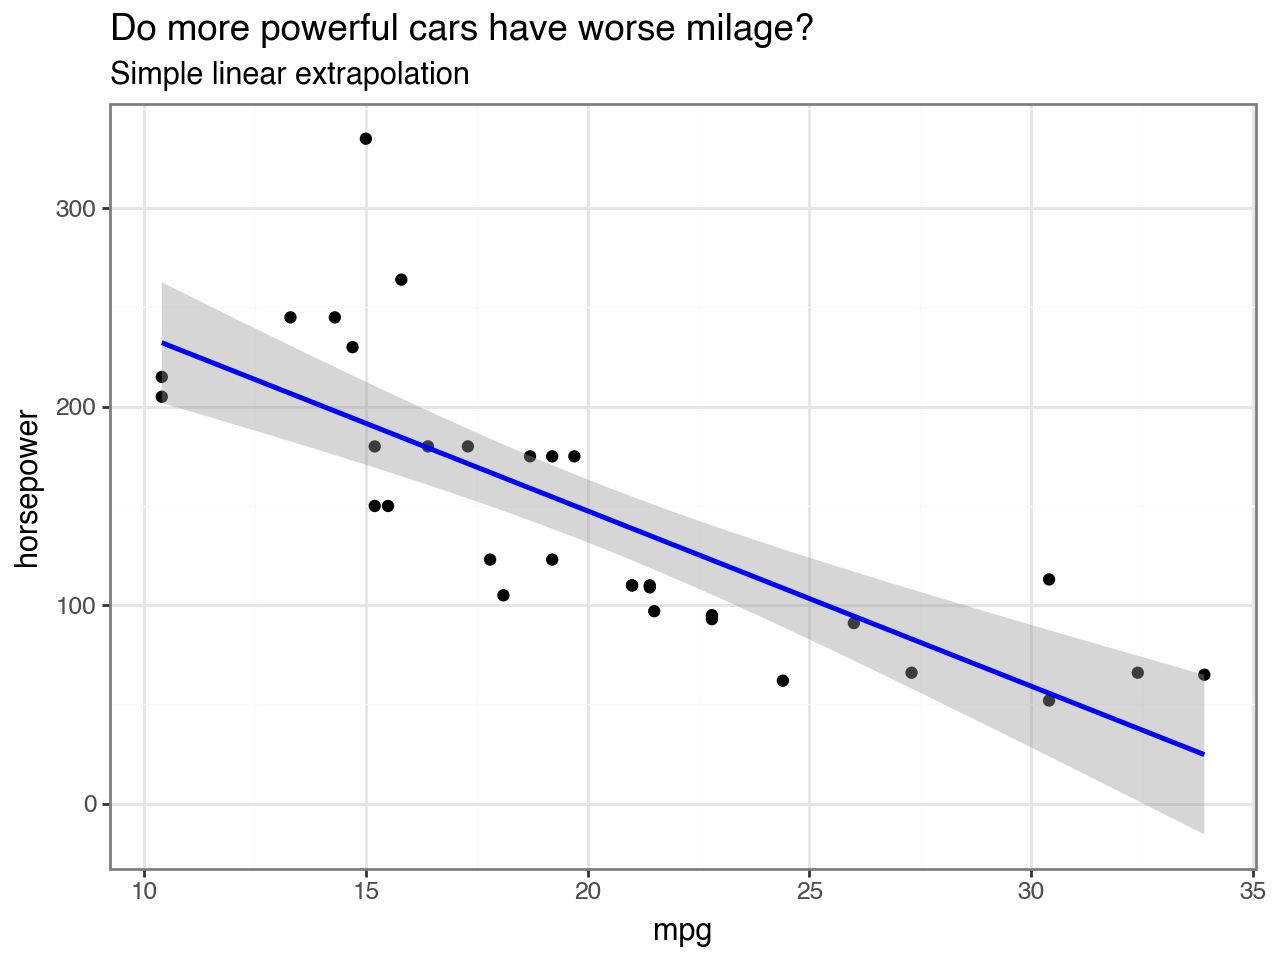

In [3]:
original + [
    p9.geom_smooth(method='lm', color='blue'),
    p9.labs(title='Do more powerful cars have worse milage?',
            subtitle='Simple linear extrapolation', 
            y='horsepower'),
    p9.theme_bw()
]

You would not trust that linear extrapolation as it is starting to head below zero. There are more sophisticated smoothing options (e.g. using `'loess'` as the method instead of `'lm'`) but they have additional dependencies. The emphasis here is on plotting.

# More useful example - event annotation

The example above was a simple example, but not particularly motivating. Let's look at an example of a conversion rate from emails.

This is a graph you produce frequently, so you have a function for it

In [4]:
#| echo: False
# This is a cell for generating the data
import pandas as pd
import numpy as np

np.random.seed(42)

sends = np.random.poisson([100_000]*60 + [800_000]*31)
conv_rate = [0.015] * 20 + [0.0151, 0.0152, 0.0153, 0.0156, 0.0158, 0.016, 0.0162] + [0.018] * 33 + [0.016]*31
click_thru = np.random.binomial(sends, conv_rate)
df = pd.DataFrame({
    'date': pd.date_range(start='2024-02-01', end='2024-05-01'),
    'recipients': sends,
    'clicks': click_thru
}).assign(ctr=lambda row: row.clicks / row.recipients)

df.to_csv('email.csv', index=False)


In [5]:
import pandas as pd
import plotnine as p9

emails = pd.read_csv('email.csv')
emails['date'] = pd.to_datetime(emails['date'])
emails.head()

,date,recipients,clicks,ctr
0,2024-02-01,99886,1456,0.014577
1,2024-02-02,100220,1491,0.014877
2,2024-02-03,99637,1498,0.015035
3,2024-02-04,99344,1543,0.015532
4,2024-02-05,100091,1559,0.015576


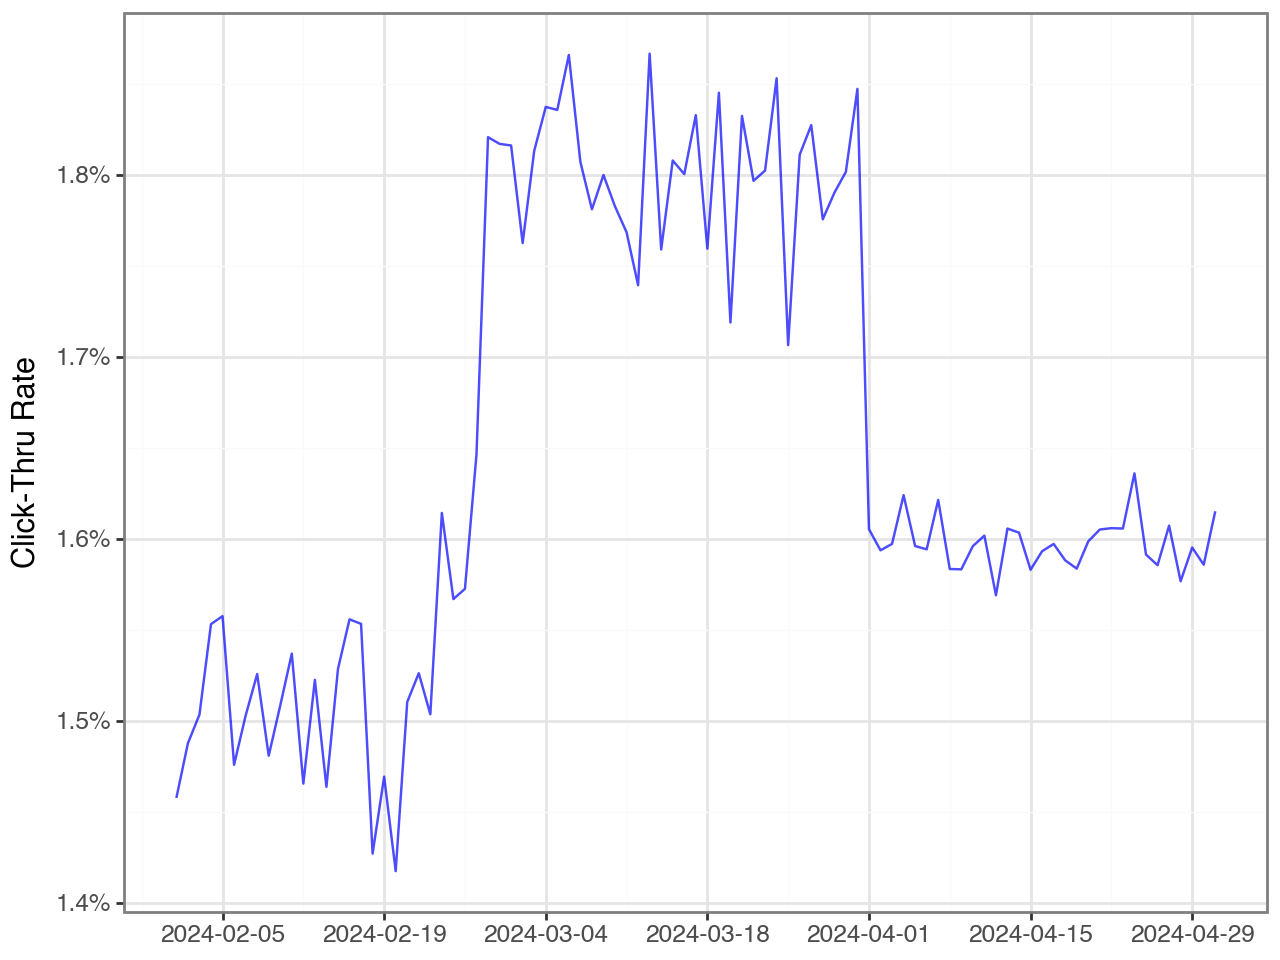

In [6]:
def make_ctr_plot(email_df):
    """Creates a plotnine plot of email conversion rates against time
    
    email_df contains the following columns
        - date (as a datetime object)
        - ctr (click through rate, in the range 0-1)
    """
    assert 'date' in email_df, 'need a date column'
    assert 'ctr' in email_df, 'need a ctr column'
    return (
        p9.ggplot(email_df, p9.aes(x='date', y='ctr'))
        + p9.geom_line(color='blue', alpha=0.7)
        + p9.scale_y_continuous(labels=lambda labs:[f"{value:.1%}" for value in labs])
        + p9.scale_x_date(breaks='2 week')
        + p9.labs(x="", y="Click-Thru Rate")
        + p9.theme_bw()
    )

make_ctr_plot(emails)

We see in the marketing department materials that they launched a new template on 2024-02-21, which helps explain the increase.

It is less clear what happened on April 1st which caused the CTR to drop! Digging in a little bit:

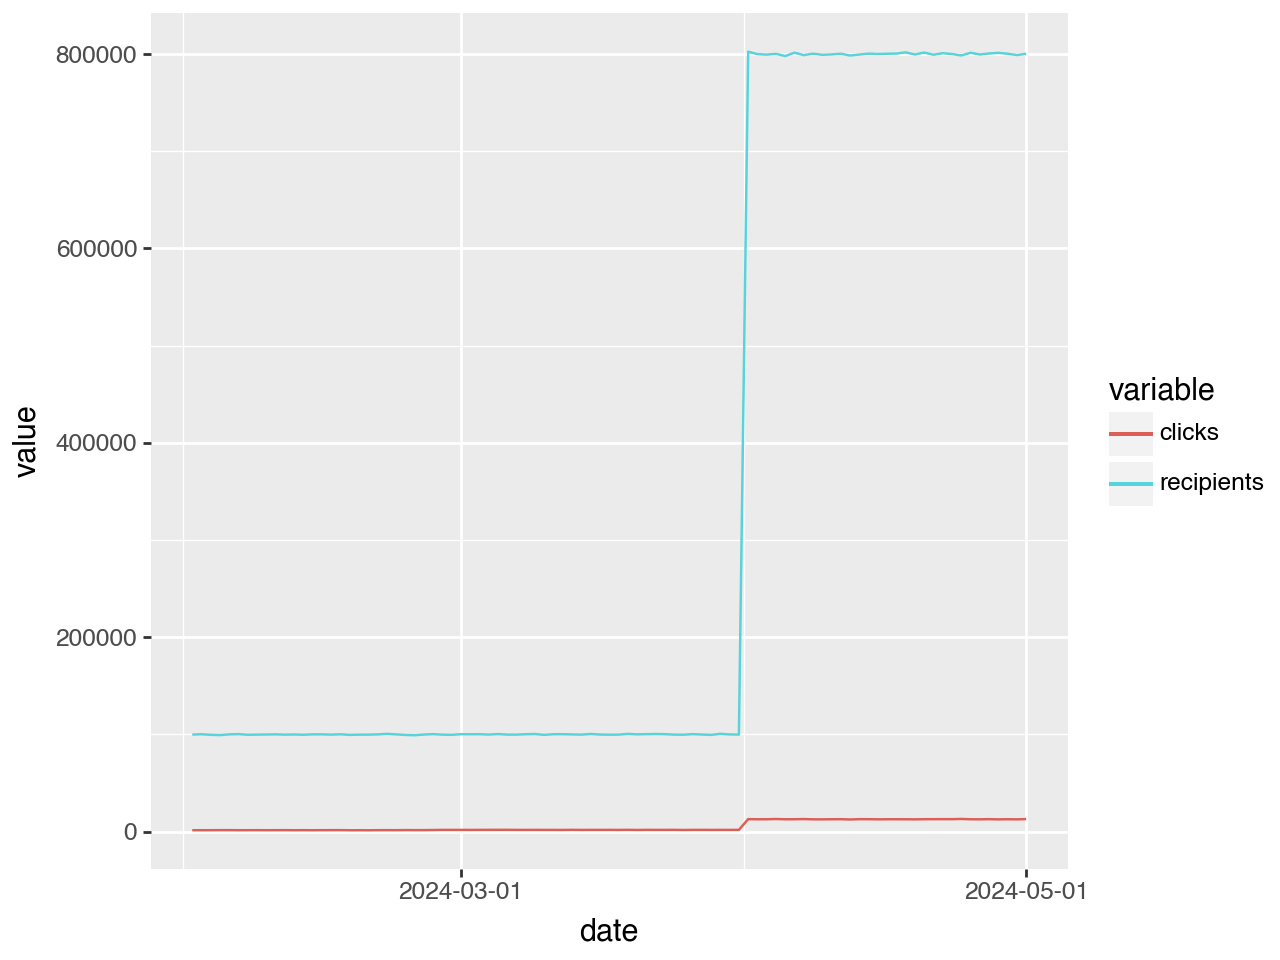

In [7]:
(
    p9.ggplot(
        emails.drop('ctr', axis=1).melt(['date']), 
        p9.aes(x='date', y='value', color='variable')
    )
    + p9.geom_line()
)

We see we massively expanded our audience (recipients) and clicks. It makes sense that as you expand the audience, the CTR drops. We still see incremental clicks. But it makes sense that we would want to add that information!

In [8]:
events = pd.DataFrame([
    {'date': '2024-02-19', 'label': 'New email launched'},
    {'date': '2024-04-01', 'label': 'Audience expansion via XYZ.com'}
])
events['date'] = pd.to_datetime(events['date'])
events

,date,label
0,2024-02-19,New email launched
1,2024-04-01,Audience expansion via XYZ.com


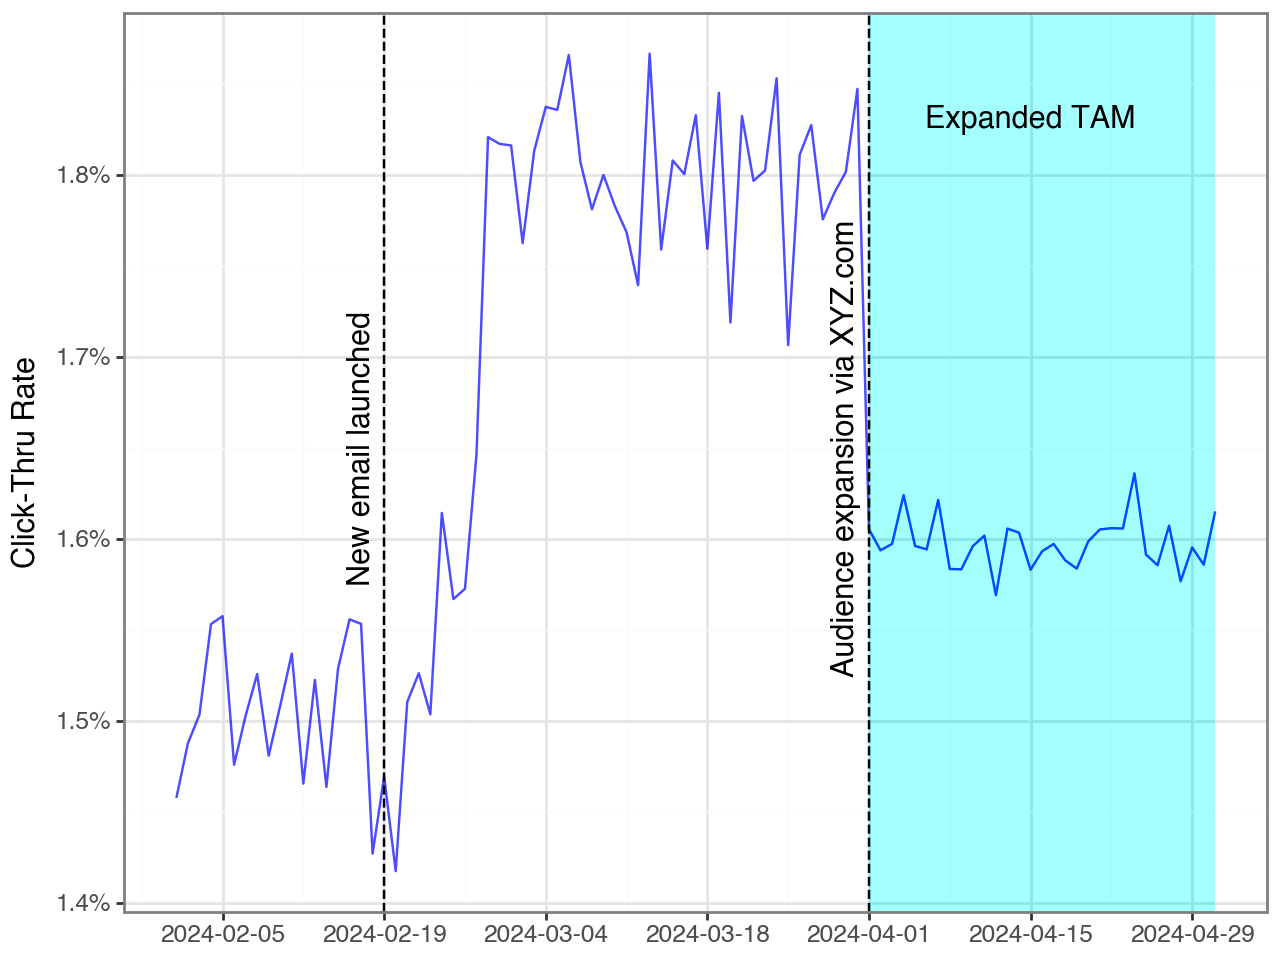

In [9]:
make_ctr_plot(emails) + [
    p9.geom_vline(mapping=p9.aes(xintercept='date'), data=events, linetype='dashed'),
    p9.geom_text(mapping=p9.aes(x='date', y=0.0165, label='label'), data=events, angle=90, nudge_x=-2),
    p9.geom_rect(mapping=p9.aes(
        xmin=pd.to_datetime('2024-04-01'), xmax=emails['date'].max(), ymin=float("-inf"), ymax=float("inf")
    ), alpha=0.005, fill='cyan'),
    p9.annotate('text', x='2024-04-15', y=0.0183, label="Expanded TAM")
]

This way we can annotate graphs to highlight special events, without having to copy all the plotting code.